In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional,GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
try:
    df = pd.read_csv("News.csv")
except FileNotFoundError:
    print("Error: File 'News.csv' not found!")
    exit()

In [3]:
df=df.drop("Unnamed: 0", axis=1)


In [4]:
df.isnull().sum()

title       0
text        0
subject    21
date       41
class      21
dtype: int64

In [5]:
df=df.dropna()

In [6]:
subject_count=df["subject"].value_counts()
subject_count

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6838
left-news           4457
Government News     1570
US_News              775
Middle-east          770
Name: count, dtype: int64

In [7]:
df['subject'] = df['subject'].replace({'politicsNews': 'Politics', 'politics': 'Politics'})

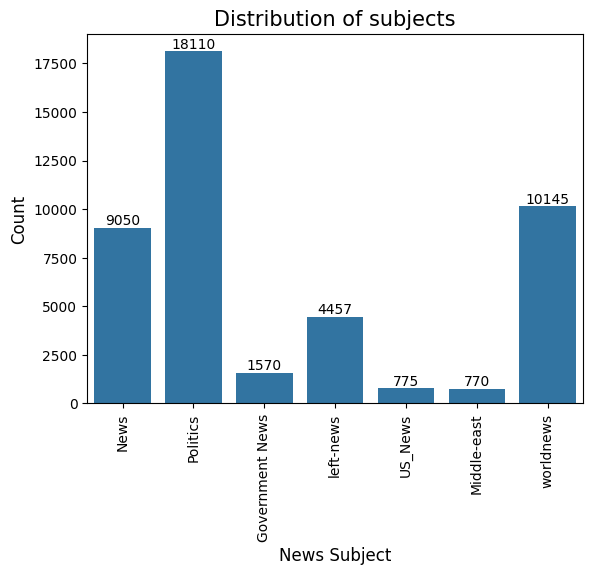

In [8]:
ax=sns.countplot(x='subject', data=df)
plt.title('Distribution of subjects', fontsize=15)
ax.bar_label(ax.containers[0])
plt.xlabel("News Subject", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=90)
plt.show()

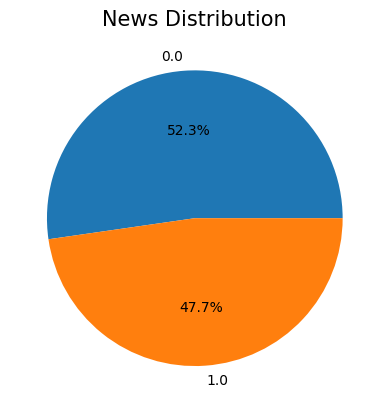

In [9]:
class_counts = df['class'].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title("News Distribution", fontsize=15)
plt.show()

In [10]:
text = ' '.join(df['text'].dropna().tolist())  # Combine all texts


In [ ]:
wordcloud= WordCloud(width=1920, height=1080).generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
df['text'] = df['title'] + " " + df['text']
df['text'] = df['text'].apply(lambda x: x.lower())

In [ ]:
df = df[['text', 'class']] 
df = df.sample(frac=1).reset_index(drop=True) 

In [ ]:
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

In [ ]:
df['text'] = df['text'].apply(remove_special_characters)

In [ ]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

In [ ]:
df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
# Tokenization and Padding
x = df['text'].tolist()
y = df['class'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [ ]:
maxlen = max([len(seq) for seq in x_train_seq + x_test_seq])

In [ ]:
x_pad_train = pad_sequences(x_train_seq, maxlen=maxlen, padding='post')
x_pad_test = pad_sequences(x_test_seq, maxlen=maxlen, padding='post')

In [ ]:
# Word2Vec
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=[doc.split() for doc in x], vector_size=DIM, window=10, min_count=1)

def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    for word, i in tokenizer.word_index.items():
        if word in model.wv:
            weight_matrix[i] = model.wv[word]
    return weight_matrix

embedded_vectors = get_weight_matrix(w2v_model)

In [ ]:
# Model Bi-directional LSTM
lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, output_dim=DIM, weights=[embedded_vectors], trainable=False))
lstm.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train and Evaluate
lstm_history = lstm.fit(x_pad_train, y_train, batch_size=64, validation_split=0.1, epochs=5)

In [ ]:
y_pred = (lstm.predict(x_pad_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
plt.plot(lstm.history['accuracy'], label='Training Accuracy')
plt.plot(lstm.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Model Bi-directional GRU

gru = Sequential()
gru.add(Embedding(input_dim=vocab_size, output_dim=DIM, weights=[embedded_vectors], trainable=False))
gru.add(Bidirectional(GRU(units=128, dropout=0.2, recurrent_dropout=0.2)))
gru.add(Dense(128, activation='relu'))
gru.add(Dropout(0.2))
gru.add(Dense(1, activation='sigmoid'))
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train and Evaluate
gru_history = gru.fit(x_pad_train, y_train, batch_size=64, validation_split=0.1, epochs=5)

In [ ]:
y_pred = (gru.predict(x_pad_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
plt.plot(gru.history['accuracy'], label='Training Accuracy')
plt.plot(gru.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Extract training accuracy for Bi-directional LSTM and GRU for comparison
lstm_accuracy = lstm_history.history['accuracy']
gru_accuracy = gru_history.history['accuracy']
epochs = range(1, len(lstm_accuracy) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, lstm_accuracy, marker='o', label='Bidirectional LSTM', color='blue')
plt.plot(epochs, gru_accuracy, marker='s', label='Bidirectional GRU', color='green')

# Adding labels, title, and legend
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)
plt.title('Training Accuracy Comparison: Bidirectional LSTM vs GRU', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.show()